In [1]:
%matplotlib inline

In [2]:
# #Download TUAB
# !rsync -auxvL --delete nedc-eeg@www.isip.piconepress.com:data/eeg/tuh_eeg_abnormal/ ./scratch/medical/eeg/tuab/ #you need the password see https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

In [3]:
# # Download TUEG
# !rsync -auxvL --delete nedc-eeg@www.isip.piconepress.com:data/eeg/tuh_eeg/ ./scratch/medical/eeg/tueg/ #you need the password see https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml

In [ ]:
!pip install -r requirements.txt
!pip uninstall -y Braindecode 
!pip install git+https://github.com/MohammadJavadD/braindecode.git@f36c42c6e8281ad6e165f7ea3d5e65a9c73da308


# Process a big data EEG resource (TUH EEG Corpus)

In this example, we showcase usage of the Temple University Hospital EEG Corpus
(https://www.isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml#c_tueg)
including simple preprocessing steps as well as cutting of compute windows.


In [5]:
# Author: Lukas Gemein <l.gemein@gmail.com>
#
# License: BSD (3-clause)

import tempfile

import numpy as np
import matplotlib.pyplot as plt
import mne
from torch.utils.data import DataLoader


from braindecode.datasets import TUH
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

If you want to try this code with the actual data, please delete the next
section. We are required to mock some dataset functionality, since the data
is not available at creation time of this example.



In [6]:
from braindecode.datasets.tuh import  TUH  # noqa F811

We start by creating a TUH dataset. First, the class generates a description
of the recordings in `TUH_PATH` (which is later accessible as
`tuh.description`) without actually touching the files. This will parse
information from file paths such as patient id, recording data, etc and should
be really fast. Afterwards, the files are sorted chronologically by year,
month, day, patient id, recording session and segment.
In the following, a subset of the description corresponding to `recording_ids`
is used.
Afterwards, the files will be iterated a second time, slower than before.
The files are now actually touched. Additional information about subjects
like age and gender are parsed directly from the EDF file header. If existent,
the physician report is added to the description. Furthermore, the recordings
are read with `mne.io.read_raw_edf` with `preload=False`. Finally, we will get
a `BaseConcatDataset` of `BaseDatasets` each holding a single
`nme.io.Raw` which is fully compatible with other braindecode functionalities.



In [ ]:
TUH_PATH = './scratch/medical/eeg/tueg_small/'
N_JOBS = 4  # specify the number of jobs for loading and windowing
tuh = TUH(
    path=TUH_PATH,
    recording_ids=None,
    target_name=('age', 'gender'),  # use both age and gender as decoding target
    preload=False,
    add_physician_reports=False,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)
tuh.description

We can easily create descriptive statistics using the description `DataFrame`,
for example an age histogram split by gender of patients.



Text(0, 0.5, 'Count')

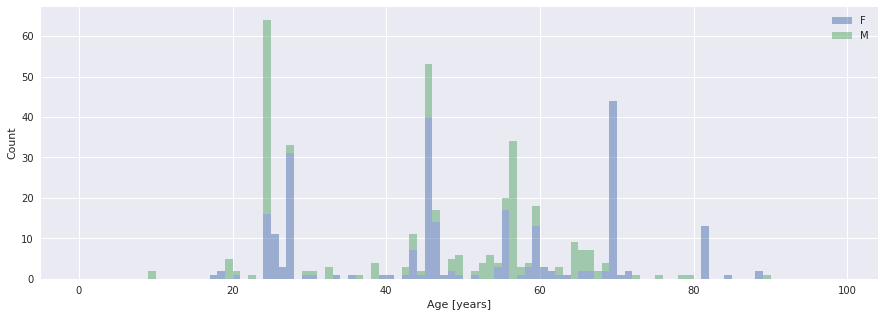

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
genders = tuh.description.gender.unique()
x = [tuh.description.age[tuh.description.gender == g] for g in genders]
ax.hist(
    x=x,
    stacked=True,
    bins=np.arange(100, dtype=int),
    alpha=.5,
)
ax.legend(genders)
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')

Next, we will perform some preprocessing steps. First, we will do some
selection of available recordings based on the duration. We will select those
recordings, that have at least five minutes duration. Data is not loaded here.



In [9]:
def select_by_duration(ds, tmin=0, tmax=None):
    if tmax is None:
        tmax = np.inf
    # determine length of the recordings and select based on tmin and tmax
    split_ids = []
    for d_i, d in enumerate(ds.datasets):
        duration = d.raw.n_times / d.raw.info['sfreq']
        if tmin <= duration <= tmax:
            split_ids.append(d_i)
    splits = ds.split(split_ids)
    split = splits['0']
    return split


tmin = 5 * 60
tmax = None
tuh = select_by_duration(tuh, tmin, tmax)

Next, we will discard all recordings that have an incomplete channel
configuration (wrt the channels that we are interested in, i.e. the 21
channels of the international 10-20-placement). The dataset is subdivided into
recordings with 'le' and 'ar' reference which we will have to consider. Data
is not loaded here.



In [10]:
short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']


tuh = select_by_channels(tuh, ch_mapping)

Next, we will chain several preprocessing steps that are realized through
`mne`. Data will be loaded by the first preprocessor that has a mention of it
in brackets:

#. crop the recordings to a region of interest
#. re-reference all recordings to 'ar' (requires load)
#. rename channels to short channel names
#. pick channels of interest
#. scale signals to micro volts (requires load)
#. clip outlier values to +/- 800 micro volts (requires load)
#. resample recordings to a common frequency (requires load)



In [11]:
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)


tmin = 1 * 60
tmax = 6 * 60
sfreq = 100

preprocessors = [
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=False,
                 apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    Preprocessor(custom_rename_channels, mapping=ch_mapping,
                 apply_on_array=False),
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    Preprocessor(multiply, factor=1e6, apply_on_array=True),
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
]

Next, we apply the preprocessors on the selected recordings in parallel.
We additionally use the serialization functionality of
:func:`braindecode.preprocessing.preprocess` to limit memory usage during
preprocessing (as each file must be loaded into memory for some of the
preprocessing steps to work). This also makes it possible to use the lazy
loading capabilities of :class:`braindecode.datasets.BaseConcatDataset`, as
the preprocessed data is automatically reloaded with ``preload=False``.

<div class="alert alert-info"><h4>Note</h4><p>Here we use ``n_jobs=2`` as the machines the documentation is build on
   only have two cores. This number should be modified based on the machine
   that is available for preprocessing.</p></div>



In [ ]:
OUT_PATH = tempfile.mkdtemp()  # please insert actual output directory here
# from datetime import datetime
# [ds_.raw.set_meas_date(datetime.now()) for ds_ in tuh.datasets]
tuh_preproc = preprocess(
    concat_ds=tuh,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
    # save_dir=OUT_PATH
)

We can finally generate compute windows. The resulting dataset is now ready
to be used for model training.



In [13]:
window_size_samples = 1000
window_stride_samples = 1000
# generate compute windows here and store them to disk
tuh_windows = create_fixed_length_windows(
    tuh_preproc,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    n_jobs=N_JOBS,
    mapping={'M': 0, 'F': 1},  # map non-digit targets

)
# store the number of windows required for loading later on
tuh_windows.set_description({
    "n_windows": [len(d) for d in tuh_windows.datasets]})

Iterating through the dataset gives x as ndarray(n_channels x 1000), y as
[age, gender], and ind. Let's look at the last example again.



In [14]:
x, y, ind = tuh_windows[1]
print('x shape:', x.shape)
print('y:', y)
print('ind:', ind)

x shape: (21, 1000)
y: [35, 1]
ind: [1, 7000, 8000]


We give the dataset to a pytorch DataLoader, such that it can be used for
model training.



In [15]:
dl = DataLoader(
    dataset=tuh_windows,
    batch_size=8,
    drop_last=True,
)

Iterating through the DataLoader gives batch_X as tensor(8 x n_channels x
1000), batch_y as [tensor([8 x age of subject]), tensor([8 x gender of
subject])], and batch_ind. We will iterate to the end to look at the last example
again.


In [16]:
for batch_X, batch_y, batch_ind in dl:
    # pass
    print('batch_X shape:', batch_X.shape)
    print('batch_y:', batch_y)
    print('batch_ind:', batch_ind)

batch_X shape: torch.Size([8, 21, 1000])
batch_y: [tensor([35, 35, 35, 35, 35, 35, 35, 35]), tensor([1, 1, 1, 1, 1, 1, 1, 1])]
batch_ind: [tensor([0, 1, 2, 3, 4, 5, 6, 7]), tensor([ 6000,  7000,  8000,  9000, 10000, 11000, 12000, 13000]), tensor([ 7000,  8000,  9000, 10000, 11000, 12000, 13000, 14000])]
batch_X shape: torch.Size([8, 21, 1000])
batch_y: [tensor([35, 35, 35, 35, 35, 35, 35, 35]), tensor([1, 1, 1, 1, 1, 1, 1, 1])]
batch_ind: [tensor([ 8,  9, 10, 11, 12, 13, 14, 15]), tensor([14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000]), tensor([15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000])]
batch_X shape: torch.Size([8, 21, 1000])
batch_y: [tensor([35, 35, 35, 35, 35, 35, 35, 35]), tensor([1, 1, 1, 1, 1, 1, 1, 1])]
batch_ind: [tensor([16, 17, 18, 19, 20, 21, 22, 23]), tensor([22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000]), tensor([23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000])]
batch_X shape: torch.Size([8, 21, 1000])
batch_y: [tensor([35, 35, 35

Now we can train a regressor to predict the age. Given EEG as the input and Age as the output. 
